In [71]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np


In [72]:

import torchvision
from torchvision import transforms

def load_dataset(folder_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to 32x32
        transforms.ToTensor(),       # Convert images to tensors
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    dataset = torchvision.datasets.ImageFolder(folder_path, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    return dataloader

In [142]:
# Gradient Penalty Calculation
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 3, 32, 32)

# Define the Critic (no Sigmoid)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)  
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Function to initialize weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [143]:
# Train WGAN-GP
def train_wgan(dataloader, num_epochs=200, latent_dim=100, lr=0.0001, lambda_gp=5, critic_steps=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator = Generator(latent_dim).to(device)
    critic = Critic().to(device)

    # Apply weight initialization
    generator.apply(initialize_weights)
    critic.apply(initialize_weights)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train the Critic multiple times
            for _ in range(critic_steps):
                optimizer_D.zero_grad()

                real_output = critic(real_images)
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_images = generator(z).detach()
                fake_output = critic(fake_images)

                # Compute WGAN-GP Loss
                gp = compute_gradient_penalty(critic, real_images, fake_images, device)
                loss_D = torch.mean(fake_output) - torch.mean(real_output) + lambda_gp * gp

                loss_D.backward()
                optimizer_D.step()

            # Train the Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            fake_output = critic(fake_images)

            loss_G = -torch.mean(fake_output)  # Maximize critic score for fake images
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

        if (epoch + 1) % 10 == 0:
            vutils.save_image(fake_images, f"generated_epoch_{epoch+1}.png", normalize=True)

    torch.save(generator.state_dict(), "generator.pth")

In [144]:
# Generate New Images
def generate_images(generator_path, num_images=5, latent_dim=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator(latent_dim).to(device)
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()

    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        fake_images = generator(z)  # Shape: (num_images, channels, height, width)

    for i, img in enumerate(fake_images):
        img = img.cpu().numpy()  # Convert tensor to numpy
        img = ((img + 1) / 2 * 255).astype(np.uint8)  # Normalize to [0, 255]

        if img.shape[0] == 1:  # Grayscale Image (Shape: 1, H, W)
            img = img.squeeze(0)  # Remove channel dimension
            Image.fromarray(img, mode="L").save(f"generated_{i}.png")
        elif img.shape[0] == 3:  # RGB Image (Shape: 3, H, W)
            img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) -> (H, W, C)
            Image.fromarray(img, mode="RGB").save(f"generated_{i}.png")

    print(f"Generated {num_images} images and saved them.")

In [ ]:
folder_path = r"D:\college\imp-doc\sem6\GENAI\project\new"
dataloader = load_dataset(folder_path)
train_wgan(dataloader)


Epoch [1/200] | Loss D: -21.2025 | Loss G: 1.5424
Epoch [2/200] | Loss D: -11.3652 | Loss G: 0.0228
Epoch [3/200] | Loss D: -41.2047 | Loss G: 0.2391
Epoch [4/200] | Loss D: -15.4246 | Loss G: 1.4035
Epoch [5/200] | Loss D: -28.2411 | Loss G: 0.5680
Epoch [6/200] | Loss D: -73.6091 | Loss G: 0.9317
Epoch [7/200] | Loss D: -9.5322 | Loss G: 0.2243
Epoch [8/200] | Loss D: -19.2033 | Loss G: -1.0617
Epoch [9/200] | Loss D: -17.3998 | Loss G: -0.4433
Epoch [10/200] | Loss D: -9.9669 | Loss G: 1.1586
Epoch [11/200] | Loss D: -32.2427 | Loss G: -2.5471
Epoch [12/200] | Loss D: -48.2281 | Loss G: 5.8771
Epoch [13/200] | Loss D: -43.1073 | Loss G: -4.8337
Epoch [14/200] | Loss D: -10.3696 | Loss G: 0.6186
Epoch [15/200] | Loss D: -13.4065 | Loss G: 0.8415
Epoch [16/200] | Loss D: -48.7959 | Loss G: 3.4173
Epoch [17/200] | Loss D: -32.1543 | Loss G: -7.4748
Epoch [18/200] | Loss D: -17.4136 | Loss G: -8.0137
Epoch [19/200] | Loss D: -6.2310 | Loss G: -3.4416
Epoch [20/200] | Loss D: -34.9130 | 

In [ ]:
generate_images("generator.pth")

Generated 5 images and saved them.


C:\Users\sameer\AppData\Local\Temp\ipykernel_33180\1683722680.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path, map_lo

In [141]:
import torch
import torchvision.utils as vutils

# Generate a batch of images
latent_dim = 100
generator = Generator(latent_dim)  # Ensure the generator is loaded
z = torch.randn(1, latent_dim)  # Generate a random noise vector
generated_img = generator(z)

# Save the image
vutils.save_image(generated_img, "generated_image1.png", normalize=True)
print("Image saved as 'generated_image1.png'")

Image saved as 'generated_image1.png'


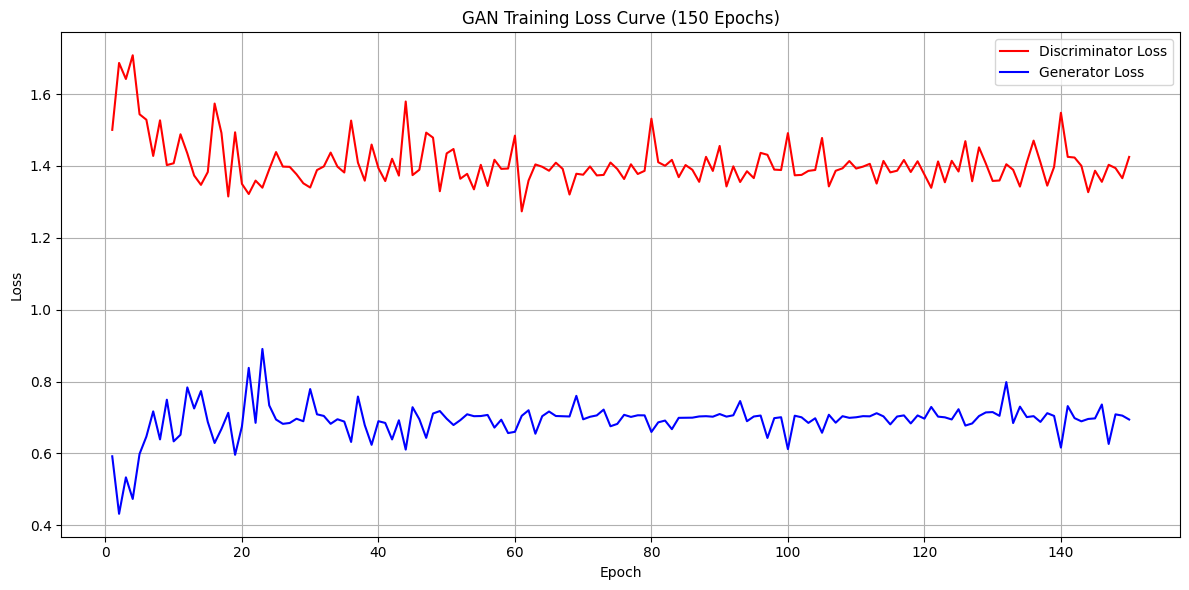

In [118]:
import matplotlib.pyplot as plt

# Paste your full loss values here
loss_D_list = [
    1.5004, 1.6866, 1.6420, 1.7080, 1.5438, 1.5286, 1.4278, 1.5270, 1.4024, 1.4075,
    1.4881, 1.4350, 1.3734, 1.3474, 1.3831, 1.5736, 1.4918, 1.3151, 1.4936, 1.3501,
    1.3219, 1.3592, 1.3395, 1.3905, 1.4386, 1.3982, 1.3975, 1.3768, 1.3517, 1.3400,
    1.3886, 1.3986, 1.4372, 1.3980, 1.3818, 1.5262, 1.4093, 1.3590, 1.4595, 1.3939,
    1.3580, 1.4200, 1.3731, 1.5793, 1.3745, 1.3894, 1.4927, 1.4788, 1.3297, 1.4349,
    1.4471, 1.3644, 1.3780, 1.3349, 1.4031, 1.3443, 1.4172, 1.3919, 1.3928, 1.4843,
    1.2737, 1.3595, 1.4042, 1.3977, 1.3867, 1.4090, 1.3918, 1.3205, 1.3783, 1.3756,
    1.3986, 1.3737, 1.3751, 1.4095, 1.3915, 1.3637, 1.4046, 1.3776, 1.3864, 1.5315,
    1.4104, 1.4005, 1.4169, 1.3688, 1.4025, 1.3893, 1.3558, 1.4253, 1.3861, 1.4557,
    1.3430, 1.3989, 1.3553, 1.3853, 1.3662, 1.4364, 1.4310, 1.3898, 1.3887, 1.4914,
    1.3740, 1.3751, 1.3863, 1.3888, 1.4779, 1.3431, 1.3866, 1.3934, 1.4136, 1.3928,
    1.3981, 1.4059, 1.3510, 1.4140, 1.3821, 1.3868, 1.4166, 1.3832, 1.4130, 1.3762,
    1.3392, 1.4125, 1.3546, 1.4143, 1.3845, 1.4690, 1.3574, 1.4517, 1.4067, 1.3583,
    1.3595, 1.4048, 1.3893, 1.3426, 1.4097, 1.4705, 1.4100, 1.3452, 1.3970, 1.5479,
    1.4253, 1.4234, 1.4004, 1.3270, 1.3867, 1.3558, 1.4032, 1.3940, 1.3659, 1.4251
]

loss_G_list = [
    0.5921, 0.4321, 0.5335, 0.4734, 0.5986, 0.6470, 0.7171, 0.6391, 0.7495, 0.6337,
    0.6520, 0.7838, 0.7252, 0.7736, 0.6877, 0.6291, 0.6681, 0.7131, 0.5962, 0.6750,
    0.8381, 0.6852, 0.8908, 0.7338, 0.6944, 0.6824, 0.6848, 0.6966, 0.6896, 0.7792,
    0.7089, 0.7044, 0.6825, 0.6952, 0.6887, 0.6320, 0.7584, 0.6788, 0.6240, 0.6898,
    0.6849, 0.6390, 0.6923, 0.6107, 0.7287, 0.6951, 0.6434, 0.7111, 0.7180, 0.6967,
    0.6791, 0.6927, 0.7090, 0.7037, 0.7041, 0.7072, 0.6720, 0.6939, 0.6567, 0.6602,
    0.7047, 0.7202, 0.6549, 0.7037, 0.7167, 0.7042, 0.7034, 0.7029, 0.7603, 0.6950,
    0.7020, 0.7059, 0.7220, 0.6757, 0.6822, 0.7075, 0.7017, 0.7062, 0.7060, 0.6598,
    0.6866, 0.6915, 0.6676, 0.6991, 0.6994, 0.6996, 0.7030, 0.7037, 0.7023, 0.7097,
    0.7025, 0.7062, 0.7458, 0.6897, 0.7028, 0.7055, 0.6431, 0.6982, 0.7008, 0.6120,
    0.7050, 0.7006, 0.6850, 0.6979, 0.6576, 0.7077, 0.6856, 0.7037, 0.6991, 0.7007,
    0.7038, 0.7033, 0.7120, 0.7032, 0.6809, 0.7028, 0.7059, 0.6836, 0.7058, 0.6969,
    0.7294, 0.7025, 0.7005, 0.6946, 0.7231, 0.6776, 0.6835, 0.7041, 0.7142, 0.7151,
    0.7047, 0.7986, 0.6846, 0.7303, 0.7012, 0.7038, 0.6878, 0.7121, 0.7044, 0.6163,
    0.7318, 0.6983, 0.6894, 0.6960, 0.6976, 0.7362, 0.6264, 0.7088, 0.7053, 0.6944
]

# Create epoch range
epochs = range(1, len(loss_D_list) + 1)

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_D_list, label="Discriminator Loss", color='red')
plt.plot(epochs, loss_G_list, label="Generator Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curve (150 Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
